In [2]:
# MNIST dataset
from pathlib import Path
import requests

DATA_PATH = Path(".datasets")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)
URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

(50000, 784)
(10000, 784)


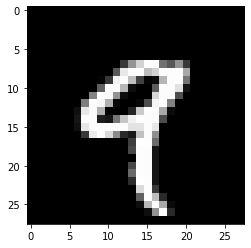

In [9]:
import pickle
import gzip
import matplotlib.pyplot as plt
import numpy as np

with gzip.open((PATH/FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
plt.imshow(x_train[4].reshape((28,28)), cmap="gray")
print(x_train.shape)
print(x_valid.shape)

In [15]:
import torch

x_train_tensor = torch.from_numpy(x_train)
y_train_tensor = torch.from_numpy(y_train)
x_valid_tensor = torch.from_numpy(x_valid)
y_valid_tensor = torch.from_numpy(y_valid)

array([5, 0, 4, ..., 8, 4, 8], dtype=int64)

In [101]:
# NN from scratch
# we initialize weigths with Xavier initialisation by multiplying by 1 / sqrt(n)
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

# activation function
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

# 784 (x) neurons and each neuron generate 10 output (y)
def model(xb):
    return log_softmax(xb @ weights + bias) # @ is dot product

# loss function
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

# for evaluation
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

loss_func = nll

bs = 64  # batch size
xb = x_train_tensor[0:bs]  # a mini-batch from x
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((100 - 1) // bs + 1): # every minibacth
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train_tensor[start_i:end_i] # get mini batch
        yb = y_train_tensor[start_i:end_i] # get mini batch
        pred = model(xb) # predictions
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
    print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(1.1416, grad_fn=<NegBackward>) tensor(0.7344)
tensor(0.6729, grad_fn=<NegBackward>) tensor(0.8594)


In [104]:
# NN with torch.nn.functional
# we initialize weigths with Xavier initialisation by multiplying by 1 / sqrt(n)
import math
import torch.nn.functional as F

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

# 784 (x) neurons and each neuron generate 10 output (y)
def model(xb):
    return xb @ weights + bias # @ is dot product

# for evaluation
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

loss_func = F.cross_entropy

bs = 64  # batch size
xb = x_train_tensor[0:bs]  # a mini-batch from x
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((100 - 1) // bs + 1): # every minibacth
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train_tensor[start_i:end_i] # get mini batch
        yb = y_train_tensor[start_i:end_i] # get mini batch
        pred = model(xb) # predictions
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
    print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(1.0767, grad_fn=<NllLossBackward>) tensor(0.7656)
tensor(0.6670, grad_fn=<NllLossBackward>) tensor(0.8281)


In [106]:
# NN with torch.nn.functional and torch.nn.Module
# we initialize weigths with Xavier initialisation by multiplying by 1 / sqrt(n)
import math
import torch.nn.functional as F
from torch import nn

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)


class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

model = Mnist_Logistic()

# for evaluation
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

loss_func = F.cross_entropy

bs = 64  # batch size
xb = x_train_tensor[0:bs]  # a mini-batch from x
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((100 - 1) // bs + 1): # every minibacth
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train_tensor[start_i:end_i] # get mini batch
        yb = y_train_tensor[start_i:end_i] # get mini batch
        pred = model(xb) # predictions
        loss = loss_func(pred, yb)

        loss.backward()
        # Notice we dont expose model params anymore!
        with torch.no_grad():
            for p in model.parameters(): 
                p -= p.grad * lr
            model.zero_grad()
    print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(1.1003, grad_fn=<NllLossBackward>) tensor(0.6875)
tensor(0.6607, grad_fn=<NllLossBackward>) tensor(0.8906)


In [108]:
# NN with torch.nn.functional and torch.nn.Module and nn.Linear
# we initialize weigths with Xavier initialisation by multiplying by 1 / sqrt(n)
import math
import torch.nn.functional as F
from torch import nn

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)


class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10) # Notice we don't expose weights and bias params

    def forward(self, xb):
        return self.linear(xb)

model = Mnist_Logistic()

# for evaluation
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

loss_func = F.cross_entropy

bs = 64  # batch size
xb = x_train_tensor[0:bs]  # a mini-batch from x
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((100 - 1) // bs + 1): # every minibacth
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train_tensor[start_i:end_i] # get mini batch
        yb = y_train_tensor[start_i:end_i] # get mini batch
        pred = model(xb) # predictions
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            for p in model.parameters(): 
                p -= p.grad * lr
            model.zero_grad()
    print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(1.1207, grad_fn=<NllLossBackward>) tensor(0.6406)
tensor(0.6351, grad_fn=<NllLossBackward>) tensor(0.9062)


In [111]:
# NN with torch.nn.functional and torch.nn.Module and nn.Linear and optim
# we initialize weigths with Xavier initialisation by multiplying by 1 / sqrt(n)
import math
import torch.nn.functional as F
from torch import nn
from torch import optim

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)


class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)

    def forward(self, xb):
        return self.linear(xb)

model = Mnist_Logistic()

# for evaluation
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

loss_func = F.cross_entropy

bs = 64  # batch size
xb = x_train_tensor[0:bs]  # a mini-batch from x
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for
opt = optim.SGD(model.parameters(), lr=lr) # optimizer defined here

for epoch in range(epochs):
    for i in range((100 - 1) // bs + 1): # every minibacth
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train_tensor[start_i:end_i] # get mini batch
        yb = y_train_tensor[start_i:end_i] # get mini batch
        pred = model(xb) # predictions
        loss = loss_func(pred, yb)

        loss.backward()
        # Notice we don't have to loop over model parameters by hand
        opt.step()
        opt.zero_grad()
    print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(1.1159, grad_fn=<NllLossBackward>) tensor(0.6875)
tensor(0.6683, grad_fn=<NllLossBackward>) tensor(0.8594)


In [112]:
# Pytorch has abstract class for custom dataset named Dataset. TensorDataset is wrapper for this class.
# We can iterate both x and y set same time.
import math
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train_tensor, y_train_tensor)

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)


class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)

    def forward(self, xb):
        return self.linear(xb)

model = Mnist_Logistic()

# for evaluation
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

loss_func = F.cross_entropy

bs = 64  # batch size
xb = x_train_tensor[0:bs]  # a mini-batch from x
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for
opt = optim.SGD(model.parameters(), lr=lr) # optimizer defined here

for epoch in range(epochs):
    for i in range((100 - 1) // bs + 1): # every minibacth
        xb,yb = train_ds[i*bs : i*bs+bs] # Notice how we iterate
        pred = model(xb) # predictions
        loss = loss_func(pred, yb)

        loss.backward()
        # Notice we don't have to loop over model parameters by hand
        opt.step()
        opt.zero_grad()
    print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(1.1283, grad_fn=<NllLossBackward>) tensor(0.7031)
tensor(0.6430, grad_fn=<NllLossBackward>) tensor(0.9219)


In [114]:
# Pytorch's DataLoader class is responsible for loading mini-batches. With help of this class we can
# write much cleaner train loops.

import math
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)


class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)

    def forward(self, xb):
        return self.linear(xb)

model = Mnist_Logistic()

# for evaluation
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

loss_func = F.cross_entropy

bs = 64  # batch size
xb = x_train_tensor[0:bs]  # a mini-batch from x
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for
opt = optim.SGD(model.parameters(), lr=lr) # optimizer defined here
train_ds = TensorDataset(x_train_tensor, y_train_tensor) #  Tensor dataset object
train_dl = DataLoader(train_ds, batch_size=bs) # DataLoader object

# OMG so clean!
for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1097, grad_fn=<NllLossBackward>) tensor(1.)
tensor(0.0811, grad_fn=<NllLossBackward>) tensor(1.)


In [117]:
import math
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)


class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)

    def forward(self, xb):
        return self.linear(xb)

model = Mnist_Logistic()

# for evaluation
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

loss_func = F.cross_entropy

bs = 64  # batch size
xb = x_train_tensor[0:bs]  # a mini-batch from x
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for
opt = optim.SGD(model.parameters(), lr=lr) # optimizer defined here

#  Tensor dataset object we also shuffle the dataset here
train_ds = TensorDataset(x_train_tensor, y_train_tensor) 
train_dl = DataLoader(train_ds, batch_size=bs) # DataLoader object

valid_ds = TensorDataset(x_valid_tensor, y_valid_tensor) # No need shuffle for validation set
# We can use larger batch size because validation don't need calc back prop so uses less memory.
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

# OMG so clean!
for epoch in range(epochs):
    model.train() # this phases are important while using batchnorm and dropout
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval() # this phases are important while using batchnorm and dropout
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
    print(epoch, valid_loss / len(valid_dl))
    #print(loss_func(model(xb), yb), accuracy(model(xb), yb))

0 tensor(0.3090)
1 tensor(0.2898)


In [110]:
xb_valid = x_valid_tensor[:64]
yb_valid = y_valid_tensor[:64]

print(loss_func(model(xb_valid), yb_valid), accuracy(model(xb), yb))

tensor(1.5711, grad_fn=<NllLossBackward>) tensor(0.8906)


In [49]:
xb_valid.shape

torch.Size([64, 784])

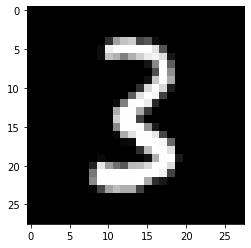

In [53]:
xb_valid[0].reshape(28, 28)
plt.imshow(xb_valid[0].reshape(28, 28), cmap="gray")

In [62]:
p = model(torch.unsqueeze(xb_valid[0], dim=0))
p

tensor([[-2.6155, -0.9929, -1.5386, -2.7747, -3.2980, -3.3874, -3.2308, -3.4792,
         -2.1557, -3.8000]], grad_fn=<SubBackward0>)

In [91]:
# Using torch.nn.Module

from torch import nn
from torch import optim

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)

In [92]:
model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=0.05)

In [93]:
for epoch in range(epochs):
    for i in range((100-1)//bs+1): # every minibatch
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train_tensor[start_i:end_i]
        yb = y_train_tensor[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [94]:
print(loss_func(model(xb), yb))

tensor(1.9465, grad_fn=<NllLossBackward>)


In [ ]:
'''
with torch.no_grad():
    for p in model.parameters():
        p -= p.grad * lr
        model.zero_grad()
this block can supress with follwing lines:
opt.step()
opt.zero_grad()
'''